In [15]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split


dataset = 'data.csv'
df_raw = pd.read_csv(dataset, on_bad_lines='skip')
df_raw.dropna(inplace=True)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def feature_creation(df : pd.DataFrame) -> pd.DataFrame:
    df_raw.dropna(inplace=True)
    df['password'] = df['password'].astype(str)
    df['length'] = df['password'].apply(len)
    df['caps_alpbts'] = df['password'].apply(lambda x : len(re.findall('[A-Z]', x)))/df['length']
    df['small_alpbts'] = df['password'].apply(lambda x : len(re.findall('[a-z]', x)))/df['length']
    df['num'] = df['password'].apply(lambda x : len(re.findall('[0-9]', x)))/df['length']
    df['comon_chars'] = df['password'].apply(lambda x : len(re.findall('[@_!#$%^&*()<>?/\\|{ }~:\\[\\]]', x)))/df['length']
    df['unique_chars'] = df['password'].apply(lambda x : len(re.findall('[^a-zA-Z0-9@_!#$%^&*()+-<>?/\|{ }~:\\[\\]]', x)))/df['length']
    return df

df = feature_creation(df_raw)

x_temp = np.array(df["password"])
y = np.array(df["strength"])

In [17]:
# Trasformazione TF-IDF

tfidf = TfidfVectorizer(analyzer="char", lowercase=False, token_pattern=None)
x_temp = tfidf.fit_transform(x_temp).toarray()

print('Shape x_temp :', x_temp.shape)
print('Shape df :', df.iloc[:,3:].shape)

Shape x_temp : (669639, 200)
Shape df : (669639, 5)


In [18]:
x = np.concatenate((x_temp, df.iloc[:,3:].values), axis=1)
x.shape

(669639, 205)

In [19]:
# Combinazione delle caratteristiche TF-IDF con le caratteristiche manuali
np.concatenate((tfidf.get_feature_names_out(), df.columns[3:]))

array(['\x01', '\x02', '\x04', '\x05', '\x06', '\x08', '\x0e', '\x0f',
       '\x10', '\x11', '\x12', '\x13', '\x16', '\x17', '\x18', '\x19',
       '\x1b', '\x1c', '\x1d', '\x1e', ' ', '!', '"', '#', '$', '%', '&',
       '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']',
       '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
       'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
       'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x81', '\x8d', '\xa0',
       '¡', '¢', '¤', '¦', '§', '¨', '«', '¯', '°', '±', '²', '³', '´',
       'µ', '¶', '·', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â',
       'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'É', 'Ê', 'Í', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó',
       'Ô', 'Õ', 'Ö', '×', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß',

In [20]:
list(df.columns[3:])

['caps_alpbts', 'small_alpbts', 'num', 'comon_chars', 'unique_chars']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [22]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

print("Score of the model is", rf_model.score(x_test, y_test))
print(classification_report(y_test, rf_pred))

Score of the model is 0.9919732990860761


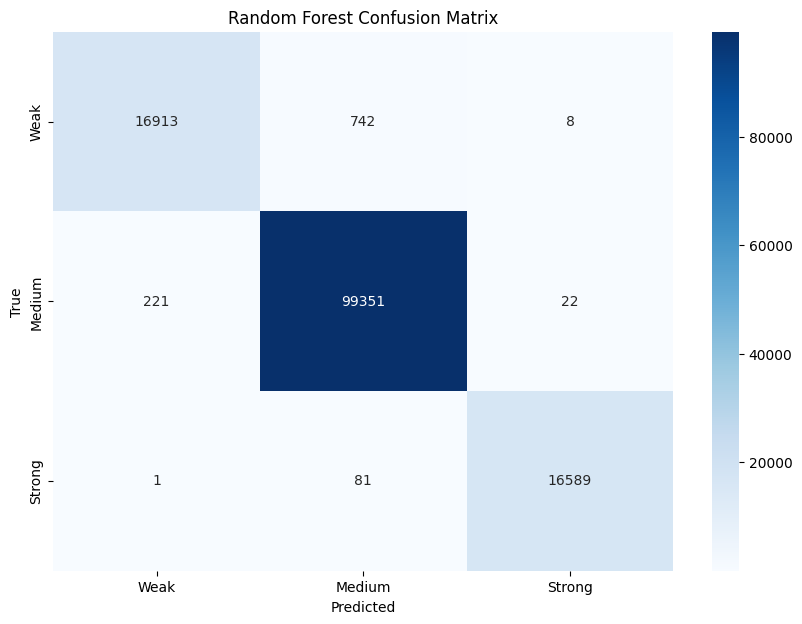

In [24]:
# Confusion matrix for RandomForestClassifier
rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Weak', 'Medium', 'Strong'], yticklabels=['Weak', 'Medium', 'Strong'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train, y_train)
logistic_pred = logistic_model.predict(x_test)

logistic_model.score(x_test, y_test)

print(classification_report(y_test, logistic_pred))

              precision    recall  f1-score   support

           0       0.58      0.30      0.40     17663
           1       0.88      0.95      0.91     99594
           2       0.96      0.92      0.94     16671

    accuracy                           0.86    133928
   macro avg       0.80      0.73      0.75    133928
weighted avg       0.85      0.86      0.85    133928



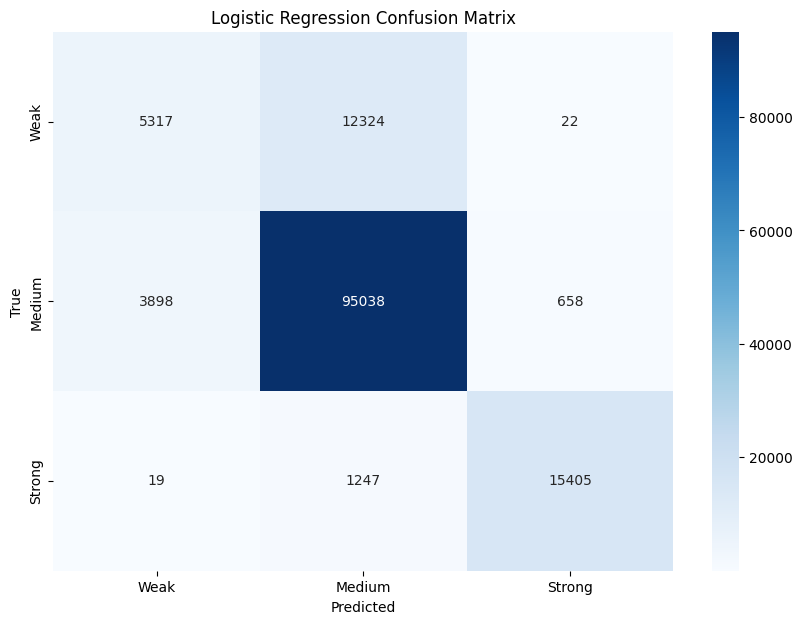

In [26]:
# Confusion matrix for LogisticRegression
logistic_cm = confusion_matrix(y_test, logistic_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(logistic_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Weak', 'Medium', 'Strong'], yticklabels=['Weak', 'Medium', 'Strong'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
from sklearn.svm import LinearSVC

# Modello Linear SVM
linear_svm_model = LinearSVC()
linear_svm_model.fit(x_train, y_train)
linear_svm_pred = linear_svm_model.predict(x_test)

linear_svm_model.score(x_test, y_test)

print(classification_report(y_test, linear_svm_pred))


              precision    recall  f1-score   support

           0       0.60      0.22      0.32     17663
           1       0.86      0.96      0.91     99594
           2       0.93      0.91      0.92     16671

    accuracy                           0.86    133928
   macro avg       0.80      0.70      0.72    133928
weighted avg       0.84      0.86      0.84    133928



In [30]:
from sklearn.metrics import hinge_loss

def track_logistic_loss(X_train, y_train, X_test, y_test, max_iter=1000, tol=1e-3):
    model = SGDClassifier(loss='log', max_iter=1, warm_start=True, tol=tol, random_state=0)
    loss_history = []
    for i in range(max_iter):
        model.fit(X_train, y_train)  # Fit one iteration
        y_pred_prob = model.predict_proba(X_test)  # Get predicted probabilities
        loss = hinge_loss(y_test, y_pred_prob)  # Compute hinge loss
        loss_history.append(loss)
        if len(loss_history) > 1 and abs(loss_history[-1] - loss_history[-2]) < tol:
            break
    return loss_history

              precision    recall  f1-score   support

           0       0.75      0.00      0.00     17663
           1       0.84      0.98      0.91     99594
           2       0.89      0.90      0.90     16671

    accuracy                           0.84    133928
   macro avg       0.83      0.63      0.60    133928
weighted avg       0.83      0.84      0.79    133928



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


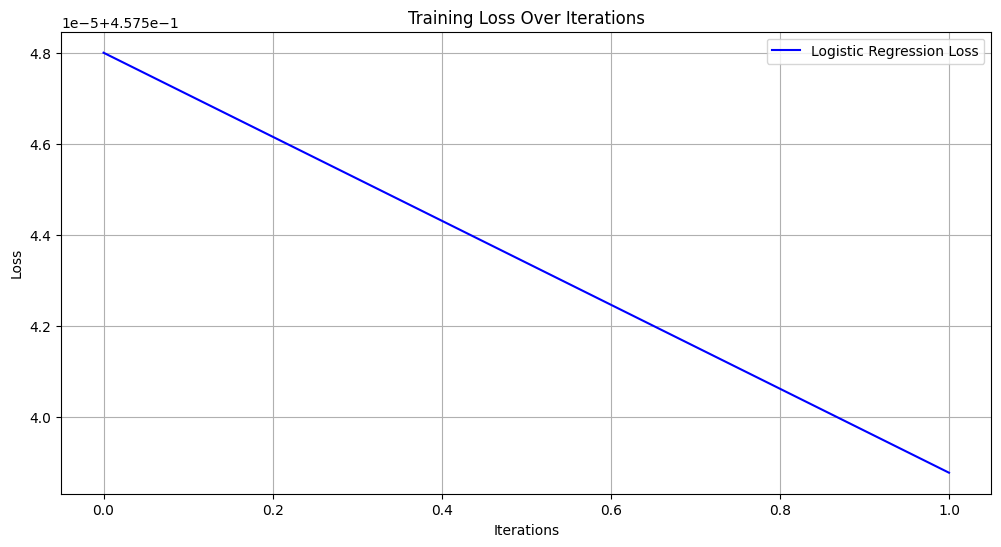

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

# Track Logistic Loss
model = SGDClassifier() # stochastic gradient descent, it processes mini-batches of data, making it suitable for datasets that do not fit into memory.
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

logistic_loss_values = track_logistic_loss( x_train, y_train, x_test, y_test)

plt.figure(figsize=(12, 6))
plt.plot(logistic_loss_values, label='Logistic Regression Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()